In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from classical_betti_calc import boundary, homology, betti
from utils import make_simplicies
import seaborn as sns

sns.set_theme()
np.random.seed(0)

In [2]:
# As before, we will get the data and process it to get point clouds
data, targets = load_digits(return_X_y=True)

data = data[np.logical_or(targets == 0, targets == 1)]
targets = targets[np.logical_or(targets == 0, targets == 1)]

data[data < 8] = 0
data[data >= 8] = 1
data = data.reshape(len(data), 8, 8)

In [3]:
def make_vertices(image):
    vertices = []
    for i, row in enumerate(image):
        for j, pixel in enumerate(row):
            if pixel > 0.5:
                vertices.append([j, i])
    return np.array(vertices)

In [4]:
all_vertices = np.array([make_vertices(x) for x in data], dtype=object)

In [5]:
def get_distances(max_l=3):
    distances = []
    for x in range(max_l):
        for y in range(x + 1):
            distances.append(np.sqrt(x**2 + y**2))
    return distances

In [6]:
possible_edge_ls = get_distances(4)
possible_edge_ls.pop(0)
possible_edge_ls=possible_edge_ls[:-2]
# We will sweep over these edge lengths to see its effect

In [7]:
all_accs = [[], []]
for edge_l in possible_edge_ls:
    scs = make_simplicies(all_vertices, edge_l, 3)

    new_features = []
    for i, sc in enumerate(scs):
        bnd, simplicies = boundary(sc)
        H = homology(bnd)
        b = betti(H)
        new_features.append([b[0], b[1]])

    new_features = np.array(new_features)
    X_train, X_test, y_train, y_test = train_test_split(
        new_features, targets, test_size=0.3, stratify=targets, random_state=0
    )

    models = [LogisticRegression()]
    print(edge_l)
    for model in models:
        model.fit(X_train, y_train)
        y_predict_test = model.predict(X_test)
        y_predict_train = model.predict(X_train)

        test_acc = accuracy_score(y_test, y_predict_test)
        train_acc = accuracy_score(y_train, y_predict_train)
    all_accs[0].append(train_acc)
    all_accs[1].append(test_acc)

1.0
1.4142135623730951
2.0
2.23606797749979
2.8284271247461903
3.0
3.1622776601683795


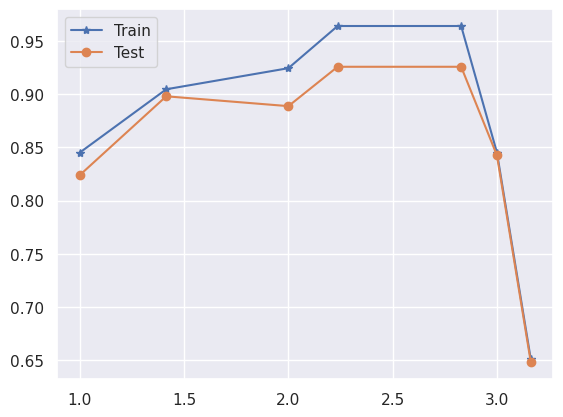

In [8]:
plt.plot(possible_edge_ls, all_accs[0], "*-")
plt.plot(possible_edge_ls, all_accs[1], "o-")
plt.legend(["Train", "Test"])
plt.show()

We see that there is an optimal edge length for which the classifier performs much better.

This suggests using it as an hyperparameter to tune the models.

On the other hand, there are persistant Betti numbers which do not depend on edge lengths. Estimating those and using them as features is one of the planned future tasks.